[442.0, 425.60759493670884, 409.2151898734177, 392.82278481012656, 376.43037974683546, 360.0379746835443, 343.6455696202531, 327.253164556962, 312.5, 312.5, 312.5, 312.5, 312.5]
[582.0, 582.4069767441861, 582.8139534883721, 583.2209302325581, 583.6279069767442, 584.0348837209302, 584.4418604651163, 584.8488372093024, 585.2558139534884, 585.5, 585.5, 585.5, 585.5, 585.5]
[587.0, 587.4651162790698, 587.9302325581396, 588.3953488372093, 588.8604651162791, 589.3255813953489, 589.7906976744187, 590.2558139534884, 590.7209302325581, 591.0, 591.0, 591.0, 591.0, 591.0]
[593.0, 593.5232558139535, 594.046511627907, 594.5697674418604, 595.0930232558139, 595.6162790697674, 596.1395348837209, 596.6627906976744, 597.1860465116279, 597.5, 597.5, 597.5, 597.5, 597.5]
[495.0, 495.0581395348837, 495.1162790697674, 495.1744186046512, 495.2325581395349, 495.2906976744186, 495.3488372093023, 495.40697674418607, 495.4651162790698, 495.5, 495.5, 495.5, 495.5, 495.5]
[371.5, 371.7325581395349, 371.96511627906

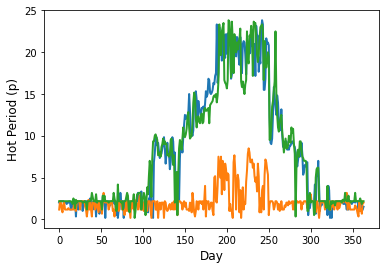

Phoenix
r = 0.8004237335722283
R squared = 0.6406781532657048
Flagstaff
r = 0.9596265761761894
R squared = 0.920883165703635
Yuma
r = 0.7459468558255364
R squared = 0.556436711716004


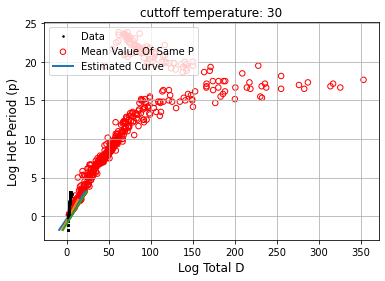

In [70]:
import matplotlib.pyplot as plt
from scipy import stats
from scipy.optimize import curve_fit
import numpy as np
import pandas as pd
import sys
sys.path.append('/_Scripts')
from _Scripts import timehorizonestimator
from _Scripts import functionapproximator


# convert to dataframe
df = [pd.read_csv("datasets/phoenixdata.csv"),
     pd.read_csv("datasets/flagstaffdata.csv"),
     pd.read_csv("datasets/yumadata.csv")]
fileNames = ["Phoenix","Flagstaff","Yuma"]
# Initialize the input variables.
dataset_num = 0
p = [[],[],[],[],[]]
xp = [[],[],[],[]] 
agg_x = [[],[],[],[]] 
agg_mu = [[],[],[],] 
g_cuttoff = 30

# Initialize the statistics visualization variables.
g_ps = [[],[],[]]
g_slopes = []
tempdiff_arr = []
g_mtrs = []
avg_mu = []
avg_lambda = []
DC_arr = [[],[],[]]

mu_diff = [[],[],[]]
lambda_diff = []
day_arr = list(range(0, 364))



def first_order_model(data, timehorizon):
    day = 0
    temperatureDayArr = []
    GHIDayArr = []
    
    # Loop through the data, grouping it into days.
    for i in np.arange(int(len(data['Minute']))):
        if (data['Minute'][i] % 1440 == 0):
            if (day > 0):
                t0, t3 = timehorizonestimator.findt0t2t3(
                    temperatureDayArr, g_cuttoff)
                t2 = int(1/3*t0 + 2/3 * t3)
                g_ps[dataset_num].append((t3-t0)/60)

                sensitivity_analysis(max(temperatureDayArr),
                                     g_cuttoff)

                mut0t2 = 0
                sum_lambda = 0
                netflow = 0
                netflowt2t3 = 0
                sum_netflow = 0
                sum_mu = 0
                sum_lambda = 0
                slope = 1  # guessed
                eqn_queue = []
                mu_arr = []

                # t0 t2
                for k in np.arange(int(t0/timehorizon), int(t2/timehorizon)+1):
                    mut0t2 = ((GHIDayArr[int(t2/timehorizon)]-GHIDayArr[int(t0/timehorizon)])/(
                        (t2-t0)/timehorizon))*(k-t0/timehorizon)+GHIDayArr[int(t0/timehorizon)]
                    mu_arr.append(mut0t2)
                    sum_mu += mut0t2
                    netflow = GHIDayArr[int(k)] - mut0t2
                    sum_netflow += netflow

                queue = sum_netflow

                # total lambda for t2 t3
                for k in np.arange(int(t2/timehorizon), int(t3/timehorizon)+1):
                    sum_lambda += GHIDayArr[int(k)]

                # approximate slope
                functionapproximator.func_approx(slope, sum_netflow, GHIDayArr[int(int(t2/timehorizon))], GHIDayArr, sum_lambda, t2, t3, timehorizon, .2, g_slopes)

                # total lambda for t0 t2
                for k in np.arange(int(t0/timehorizon), int(t2/timehorizon)+1):
                    sum_lambda += GHIDayArr[int(k)]

                slope = g_slopes[len(g_slopes) - 1]

                # t2 - t3
                for k in np.arange(0, int(t3/timehorizon)-int(t2/timehorizon)):
                    y = slope*k + GHIDayArr[int(int(t2/timehorizon))]
                    mu_arr.append(y)
                    sum_mu += y
                    netflowt2t3 = GHIDayArr[int(k) + int(t2/timehorizon)] - y
                    queue += netflowt2t3

                avg_mu.append((1 / (t3-t0)) * sum_mu)
                avg_lambda.append((1 / (t3-t0)) * sum_lambda)
                
                
                # eqn 1.1 (given)
                for k in np.arange(int(t0/timehorizon), int(t3/timehorizon)+1):
                    y = 1/3*((k - int(t0/timehorizon))**2) * (int(t3/timehorizon) - k)
                    eqn_queue.append(y)
                mu_diff[dataset_num].append(
                    mu_arr[int(t2/timehorizon)-int(t0/timehorizon)] - mu_arr[0])
                lambda_diff.append(
                    GHIDayArr[int(t2/timehorizon)] - GHIDayArr[int(t0/timehorizon)])
                
                DC_arr[dataset_num].append(sum_lambda/max(mu_arr))
                if(dataset_num == 0):
                    #print(GHIDayArr[int(t2/timehorizon)])
                    print(mu_arr)
                #print(np.max(mu_arr))
                #if(np.max(mu_arr) == 0):
                    #print(GHIDayArr)
                    #print(str(temperatureDayArr))
                    #print('Day: ' + str(day))
                    #print('t0: ' +  str(t0/timehorizon))
                    #print('t2: ' +  str(t2/timehorizon))
                    #print('t3: ' +  str(t3/timehorizon))
                    #print(slope)
                    #print(mu_arr)
                # print(eqn_queue)
                #print("queue t2 t3: " + str(queue))
                #print("queue t0 t2: " + str(sum_netflow))

            temperatureDayArr.clear()
            GHIDayArr.clear()
            day += 1
        temperatureDayArr.append(data['Average of Temperature'][i])
        GHIDayArr.append(data['Average of GHI'][i])


def sensitivity_analysis(maxtemp, cutoff):
    # mtr = magnitude of temperature reduction
    tempdiff = maxtemp - cutoff
    mtr = tempdiff/cutoff
    tempdiff_arr.append(tempdiff)
    g_mtrs.append(mtr)

def trim_values(bottom, top, val1, val2):
    #
    # print(bottom)
    temp1 = []
    temp2 = []
    for i in range(len(val1)):
        if (i >= bottom and i <= top):       
            temp1.append(val1[i])
            temp2.append(val2[i])
    return temp1, temp2
            
def plot_p():
    # Plot inflow rate
    fig = plt.figure()
    for i in range(len(df)):
        plt.plot(day_arr, g_ps[i], '-', linewidth=2, label='Inflow rate')
        plt.ylabel('Hot Period (p)', fontsize=12)
        plt.xlabel('Day', fontsize=12)
    fig.savefig('Figures/p_plot.png', dpi=300, bbox_inches='tight')
    plt.show()

# inputs: x and input_val
# input value

 

def kdaysmoothing(x, input_val):
    # Create two empty lists to store the results
    agg_x = []
    y = []

    # Loop through each value in x
    for i in range(len(x)):

        # Initialize total and count to 0
        total = 0
        count = 0

        # Loop through each value in x again
        for k in range(len(x)):

            # If the current value in x is equal to the value we're looking at,
            # add the corresponding value in input_val to the total and increment count
            if (x[i] == x[k]):
                total += input_val[k]
                count += 1

        # If count is greater than 0, calculate the average
        if (count > 0):
            average = total / count

            # Check if the average is a duplicate value in y
            dupe = False
            for j in range(len(y)):
                if (average == y[j]):
                    dupe = True

            # If the average is not a duplicate, append it to y and the corresponding value in x to agg_x
            if (dupe == False):
                y.append(average)
                agg_x.append(x[i])

    # Return the resulting lists
    return agg_x, y
    
def curve(x, a, b):
    return a * x**b

def plot_DvsP():
    # Plot inflow rate
    fig = plt.figure()
    for i in range(len(df)):
        #ps, D_C_arr = kdaysmoothing(g_ps[i], DC_arr[i])
        ps, D_C_arr = g_ps[i], DC_arr[i]
        #ps = np.log(ps)
        #D_C_arr = np.log(D_C_arr)
        #params, _ = curve_fit(curve, ps, lambda_arr)
        #print(params)
        pd.DataFrame(ps).to_csv('Ps' + str(i) + '.csv')
        pd.DataFrame(D_C_arr).to_csv('DC' + str(i) + '.csv')
        print(fileNames[i])
        print("r = " + str(stats.pearsonr(D_C_arr,ps)[0]))
        print("R squared = " + str(np.corrcoef(D_C_arr,ps)[0, 1]**2))
        cubic_fit = np.polyfit(ps, D_C_arr, 1)
        p = np.poly1d(cubic_fit)
        xp = np.linspace(min(np.log(g_ps[i])), max(np.log(g_ps[i])), 100)
        
        plt.plot(np.log(DC_arr[i]), np.log(g_ps[i]), '.', color='black', markersize=3)
        plt.scatter(D_C_arr, ps, s=30, facecolors='none', edgecolors='r')
        #plt.plot(ps, curve(ps, params[0], params[1]))

        
        plt.plot(p(xp), xp, '-', linewidth = 2, label='lienar')
    plt.legend(['Data', 'Mean Value Of Same P',
               'Estimated Curve'], loc='upper left')

    plt.ylabel('Log Hot Period (p)', fontsize=12)
    plt.xlabel('Log Total D', fontsize=12)
    
    #title = 'fp = {} s = {}'.format(params[0], params[1])
    plt.title('cuttoff temperature: ' + str(g_cuttoff))
    plt.grid()


    plt.show()
    fig.savefig('Figures/D_vs_p.png')

def plot_mtr():
    # Plot inflow rate
    ps, agg_mtr_vals = kdaysmoothing(g_ps[0], g_mtrs)
    
    params, _ = curve_fit(curve, ps, agg_mtr_vals)
    

    cubic_fit = np.polyfit(ps, agg_mtr_vals, 1)
    p = np.poly1d(cubic_fit)
    xp = np.linspace(0, 24, 100)

    fig = plt.figure()

    plt.plot(g_ps[0], g_mtrs, '.', color='black', markersize=3)
    plt.scatter(ps, agg_mtr_vals, s=30, facecolors='none', edgecolors='r')
    plt.plot(ps, curve(ps, params[0], params[1]))

    #plt.plot(xp, p(xp), '-', label='lienar')
    plt.legend(['Data', 'Mean Value Of Same P',
               'Estimated Curve'], loc='upper left')

    plt.xlabel('Hot Period (p)', fontsize=12)
    plt.ylabel('Magnitude Of Temperature Reduction', fontsize=12)
    
    title = 'fp = {} s = {}'.format(params[0], params[1])
    plt.title(title)
    plt.grid()

    plt.show()
    fig.savefig('Figures/mtr_vs_p.png')

def findbestfit(x,i):
    aggx, aggmu = kdaysmoothing(x, mu_diff[i])
    
    #print(aggx)
    
    cubic_fit = np.polyfit(aggx, aggmu, 2)
    p = np.poly1d(cubic_fit)
    xp = np.linspace(0, max(x), 500)
    return p,xp,aggx,aggmu



def plot_mu(x, x_var_name, p, xp, agg_x,agg_mu):
    
    fig = plt.figure()
    for i in range(len(df)):
        plt.plot(x[i], mu_diff[i], '.', color='black', markersize=3)
        plt.scatter(agg_x[i], agg_mu[i], s=30, facecolors='none', edgecolors='r')

        plt.plot(xp[i], p[i](xp[i]), '_')
        plt.legend(['Data', 'Mean Value Of Same ' + x_var_name,
               'Estimated Curve'], loc='upper left')

        plt.title('Difference Mu ' + 'vs ' + x_var_name)
        plt.xlabel(x_var_name, fontsize=12)
        plt.ylabel('Difference Mu', fontsize=12)
    
    plt.grid()

    plt.show()
    fig.savefig('Figures/avg_mu' + str(id(x)) + '.png')
    # approximates function from area bound and lambda(t)

def clearAll():
    global dataset_num
    dataset_num = 0
    global g_cuttoff
    g_cuttoff += 1
    
    global g_ps
    g_ps = [[],[],[]]
    
    global DC_arr
    DC_arr = [[],[],[]]
    p.clear()
    xp.clear()
    agg_x.clear()
    agg_mu.clear()

if __name__ == "__main__":
    x_value = [day_arr,day_arr]
    for i in range(14,15):
        for i in range(len(df)):
            first_order_model(df[i],10)
            dataset_num += 1
            #p[i], xp[i], agg_x[i],agg_mu[i] = findbestfit(x_value[i],i)
        plot_p()
        plot_DvsP()
        clearAll()
        
    
    #plot_mtr()
    #day_arr, mu_diff[dataset_num] = trim_values(0,364, day_arr, mu_diff[dataset_num])
    #print(p)
    #plot_mu(x_value, "P",p,xp,agg_x,agg_mu)
